# Objective of analysis
- To Understand given terminologies
- To Analyze trends in the given data
- To Develop a classification model for the column "worked"
- To Develop a regression model for the column "percentage_returns given"

# Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#Regression models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
#Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#Scoring
from sklearn.metrics import r2_score,confusion_matrix,precision_recall_fscore_support,accuracy_score

C:\Users\jgan2\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jgan2\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\jgan2\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df=pd.read_csv("XPREP8.csv")

In [3]:
df.head(0)

,Close,Volume,EMA5,EMA13,EMA26,MACD,SIGNAL,RSI,ROC,worked?,percentage_returns given


# Definitions and meanings:
- Closing Price CP :Last price of a stock being sold
- A moving average sums up the data points(CP) of a financial security over a specific time period and divides the total by the number of data points to arrive at an average. It is called a “moving” average because it is continually recalculated based on the latest price data.
- SMA and EMA:
    - SMA(n): sum of previous n data/n
    - EMA(n): [CP(n)-EMA(n-1)] x (2/n+1) + EMA(n-1)
       - EMA N , really depends on starting point, eg EMA 5 can be calculated after 5 trading days while EMA 20 takes 20 days.
- MACD
    - Moving Average Convergence
    - When MACD turns up from below zero it is considered bullish. When it turns down from above zero it is considered bearish.
    - When the MACD line crosses from below to above the signal line, the indicator is considered bullish. The further below the zero line the stronger the signal.
    - When the MACD line crosses from above to below the signal line, the indicator is considered bearish. The further above the zero line the stronger the signal.
- ROC
    - Rate of Change , basically change in stock price/ earlier price , so rate is obtained.
- RSI
    - Relative strength index
        - greater than 70 => uptrend
        - less than 50 => downtrend
       
        - in between =>normal
   

# 1) Data Engineering

- Engineering MACD to produce new columns.
- Engineered macd

At each point n,

    - val= 0
    - if crosses 0 from below, +1 to val
    - no cross , +sigmoid(signal strength) to val
    - if crosses 0 from above, -1 to val
    - if crosses signal from below , +1 to val
    - no cross, +sigmoid(signal strength) to val
    - if crosses signal from above , -1 to val
    - Final: val/2
    - strength of signal
        - MACD[n] - MACD[n-1]
        - Why signed sigmoid? to compress between -1 and 1
    




### Seperating columns and assigning them to variables and also scaling columns

In [4]:
sc=StandardScaler()
feauts=df.iloc[:,:9].values
worked=df.iloc[:,-2].values
returns=df.iloc[:,-1].values
scaledfeauts=sc.fit_transform(feauts)
returnssc=sc.fit_transform(returns.reshape(928,1))
#------------------------------------Seperating into different variables for easier access--------------------------------------
CP=feauts[:,0]
Volume=feauts[:,1]
EMA5=feauts[:,2]
EMA13=feauts[:,3]
EMA26=feauts[:,4]
MACD=feauts[:,5]
SIGNAL=feauts[:,6]
RSI=feauts[:,7]
ROC=feauts[:,8]
#-----------------------------------------Scaled Versions-----------------------------------------------------------------------
CPsc=scaledfeauts[:,0]
Volumesc=scaledfeauts[:,1]
EMA5sc=scaledfeauts[:,2]
EMA13sc=scaledfeauts[:,3]
EMA26sc=scaledfeauts[:,4]
MACDsc=scaledfeauts[:,5]
SIGNALsc=scaledfeauts[:,6]
RSIsc=scaledfeauts[:,7]
ROCsc=scaledfeauts[:,8]


### sigmoid function

In [5]:
def sigmoid(x):
    from math import exp
    return (x/ ((1 + exp(-x))* abs(x)))

### Produce Engineered MACD

In [6]:
engmacd=[1]
for i in range(1,MACD.shape[0]):
    sigstr=MACD[i]-MACD[i-1]
    val=0
    if(MACD[i-1]<0 and MACD[i]>0 ):
        val+=1
    elif(MACD[i-1]>0 and MACD[i]<0):
        val-=1
    else:
        val+=sigmoid(sigstr)
    if(MACD[i-1]<SIGNAL[i-1] and MACD[i]>SIGNAL[i] ):
        val+=1
    elif(MACD[i-1]>SIGNAL[i-1] and MACD[i]<SIGNAL[i]):
        val-=1
    else:
        val+=sigmoid(sigstr)
    engmacd.append(val/2)
df["Engineered_MACD"]=engmacd
df

,Close,Volume,EMA5,EMA13,EMA26,MACD,SIGNAL,RSI,ROC,worked?,percentage_returns given,Engineered_MACD
0,1136.95,3594297,1126.883592,1124.903001,1113.181837,12.016158,17.498908,58.490715,2.635974,1,3.135582,1.000000
1,1147.40,6885679,1133.722395,1128.116858,1115.716515,12.897172,16.578561,61.178123,3.457914,0,2.196270,0.707032
2,1160.75,8929987,1142.731597,1132.778736,1119.052329,14.505406,16.163930,64.353228,2.336346,0,1.020892,0.833166
3,1155.65,4729914,1147.037731,1136.046059,1121.763268,15.193278,15.969800,62.258378,4.192400,0,1.466707,0.665493
4,1138.60,2541804,1144.225154,1136.410908,1123.010433,14.198952,15.615630,55.727237,3.246282,0,2.986123,-0.270058
...,...,...,...,...,...,...,...,...,...,...,...,...
923,1787.15,4354074,1760.529346,1739.380217,1728.172574,12.646800,5.999303,62.175044,5.123379,0,0.288168,0.976003
924,1792.30,6034233,1771.119564,1746.940186,1732.922754,15.816717,7.962785,62.953964,5.559809,0,-0.270602,0.959686
925,1787.45,4732492,1776.563043,1752.727302,1736.961809,17.733127,9.916854,61.666071,4.989721,0,-0.450362,0.871738
926,1779.40,4326924,1777.508695,1756.537688,1740.105379,18.390337,11.611550,59.490646,4.137649,0,-1.123974,0.658633


# 2)Visualizations

### x-axis

In [7]:
days=[x for x in range(EMA5.shape[0])]

### Exploring EMA vs CP trends

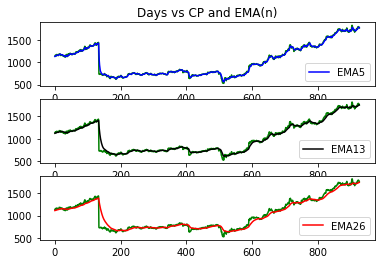

In [8]:
_,ax=plt.subplots(3,1)
ax[0].set_title("Days vs CP and EMA(n)")
ax[0].plot(days,CP,color="green")
ax[0].plot(days,EMA5,color="blue",label="EMA5")
ax[0].legend()
ax[1].plot(days,CP,color="green")
ax[1].plot(days,EMA13,color="black",label="EMA13")
ax[1].legend()
ax[2].plot(days,CP,color="green")
ax[2].plot(days,EMA26,color="red",label="EMA26")
ax[2].legend()
plt.show()


We can observe that if n is larger, it captures long-term dependency(is more resilient to sudden and sharp changes, hence can be useful for long term investments)

and if n is smaller it captures short term dependency( gives very high importance to recent data, hence useful for short term invesments)

Let us observe closely for a few amount of days, where change was sudden.

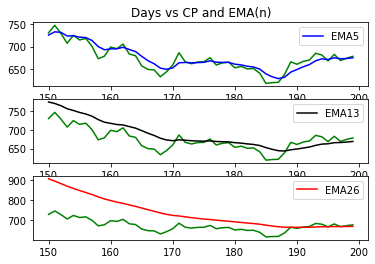

In [9]:
_,ax=plt.subplots(3,1)
ax[0].set_title("Days vs CP and EMA(n)")
ax[0].plot(days[150:200],CP[150:200],color="green")
ax[0].plot(days[150:200],EMA5[150:200],color="blue",label="EMA5")
ax[0].legend()
ax[1].plot(days[150:200],CP[150:200],color="green")
ax[1].plot(days[150:200],EMA13[150:200],color="black",label="EMA13")
ax[1].legend()
ax[2].plot(days[150:200],CP[150:200],color="green")
ax[2].plot(days[150:200],EMA26[150:200],color="red",label="EMA26")
ax[2].legend()
plt.show()


### Inference:
EMA5 reacts to quick changes in CP faster than EMA13 and EMA26. So to predict %trends and worked/not within a 7 day period, EMA5 and EMA13 would be more useful than EMA26

### Exploring trends between different feautures and % returns

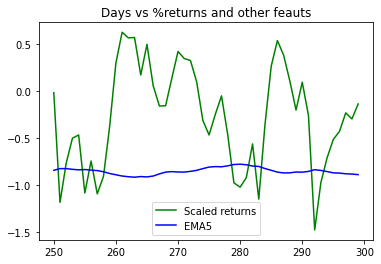

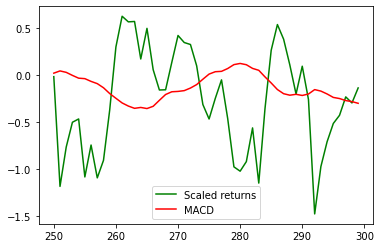

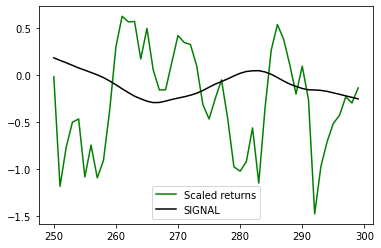

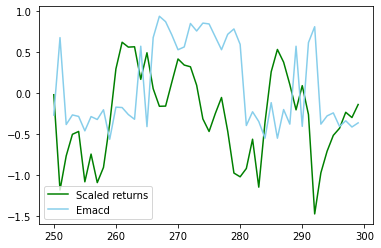

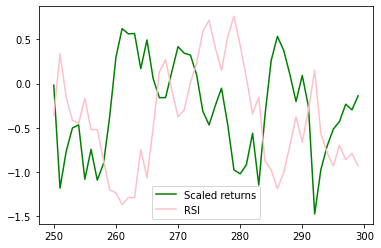

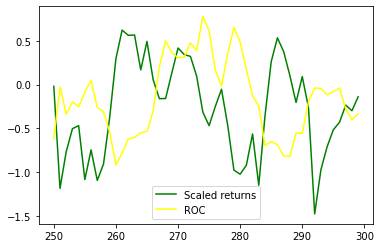

In [10]:
plt.title("Days vs %returns and other feauts")
plt.plot(days[250:300],returnssc[250:300],color="green",label="Scaled returns")
plt.plot(days[250:300],EMA5sc[250:300],color="blue",label="EMA5")
plt.legend()
plt.show()
plt.plot(days[250:300],returnssc[250:300],color="green",label="Scaled returns")
plt.plot(days[250:300],MACDsc[250:300],color="red",label="MACD")
plt.legend()
plt.show()
plt.plot(days[250:300],returnssc[250:300],color="green",label="Scaled returns")
plt.plot(days[250:300],SIGNALsc[250:300],color="black",label="SIGNAL")
plt.legend()
plt.show()
plt.plot(days[250:300],returnssc[250:300],color="green",label="Scaled returns")
plt.plot(days[250:300],engmacd[250:300],color="skyblue",label="Emacd")
plt.legend()
plt.show()
plt.plot(days[250:300],returnssc[250:300],color="green",label="Scaled returns")
plt.plot(days[250:300],RSIsc[250:300],color="pink",label="RSI")
plt.legend()
plt.show()
plt.plot(days[250:300],returnssc[250:300],color="green",label="Scaled returns")
plt.plot(days[250:300],ROCsc[250:300],color="yellow",label="ROC")
plt.legend()
plt.show()
plt.show()


### Inference
A strong feeling is present which says ROC , RSI and Engineered MACD can be used together to capture trends in % returns very well

### Testing the inference,

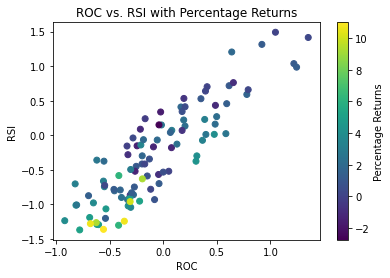

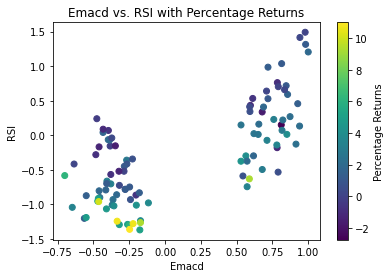

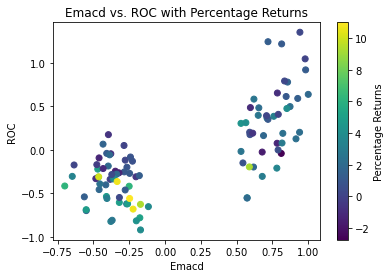

In [11]:
plt.scatter(ROCsc[250:350],RSIsc[250:350], c=returns[250:350])
plt.colorbar(label='Percentage Returns')
plt.xlabel('ROC')
plt.ylabel('RSI')
plt.title('ROC vs. RSI with Percentage Returns')
plt.show()
plt.scatter(engmacd[250:350],RSIsc[250:350], c=returns[250:350])
plt.colorbar(label='Percentage Returns')
plt.xlabel('Emacd')
plt.ylabel('RSI')
plt.title('Emacd vs. RSI with Percentage Returns')
plt.show()
plt.scatter(engmacd[250:350],ROCsc[250:350], c=returns[250:350])
plt.colorbar(label='Percentage Returns')
plt.xlabel('Emacd')
plt.ylabel('ROC')
plt.title('Emacd vs. ROC with Percentage Returns')
plt.show()

**There is existence of  some relation between Emacd,RSI,ROC with % returns.**

### Bar plots to observe seasonal trends

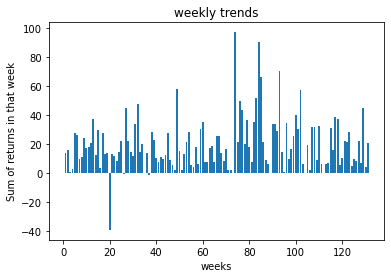

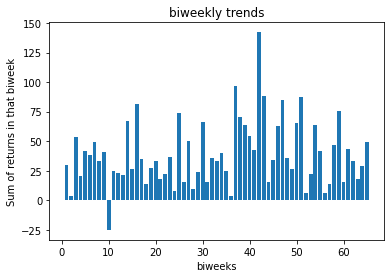

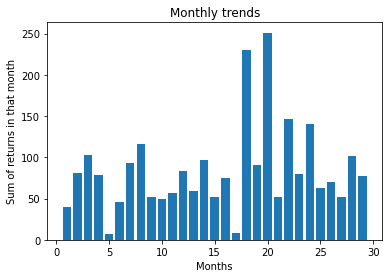

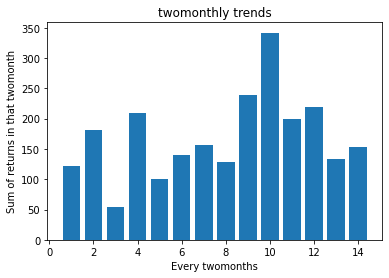

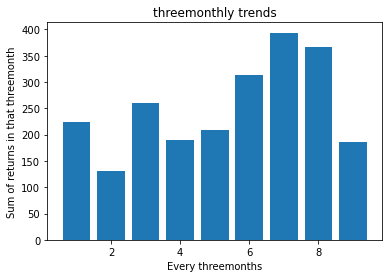

In [12]:
weekly_max_returns=[]
for i in range(1,returns.shape[0]//7):
    start=(i-1)*7
    end=i*7
    weekly_max_returns.append(sum(returns[start:end]))
weeks=[i for i in range(1,len(weekly_max_returns)+1)]
plt.bar(weeks,weekly_max_returns)
plt.title("weekly trends")
plt.xlabel("weeks")
plt.ylabel("Sum of returns in that week")
plt.show()
biweekly_max_returns=[]
for i in range(1,returns.shape[0]//14):
    start=(i-1)*14
    end=i*14
    biweekly_max_returns.append(sum(returns[start:end]))
biweeks=[i for i in range(1,len(biweekly_max_returns)+1)]
plt.bar(biweeks,biweekly_max_returns)
plt.title("biweekly trends")
plt.xlabel("biweeks")
plt.ylabel("Sum of returns in that biweek")
plt.show()
monthly_max_returns=[]
for i in range(1,returns.shape[0]//30):
    start=(i-1)*30
    end=i*30
    monthly_max_returns.append(sum(returns[start:end]))
months=[i for i in range(1,len(monthly_max_returns)+1)]
plt.bar(months,monthly_max_returns)
plt.title("Monthly trends")
plt.xlabel("Months")
plt.ylabel("Sum of returns in that month")
plt.show()
twomonthly_max_returns=[]
for i in range(1,returns.shape[0]//60):
    start=(i-1)*60
    end=i*60
    twomonthly_max_returns.append(sum(returns[start:end]))
twomonths=[i for i in range(1,len(twomonthly_max_returns)+1)]
plt.bar(twomonths,twomonthly_max_returns)
plt.title("twomonthly trends")
plt.xlabel("Every twomonths")
plt.ylabel("Sum of returns in that twomonth")
plt.show()
threemonthly_max_returns=[]
for i in range(1,returns.shape[0]//90):
    start=(i-1)*90
    end=i*90
    threemonthly_max_returns.append(sum(returns[start:end]))
threemonths=[i for i in range(1,len(threemonthly_max_returns)+1)]
plt.bar(threemonths,threemonthly_max_returns)
plt.title("threemonthly trends")
plt.xlabel("Every threemonths")
plt.ylabel("Sum of returns in that threemonth")
plt.show()


### Inference
Every peak is followed immediately by a dip, and every dip is followed by a peak. Why such a trend?

# 3)Models and Plan
- We will build a set of classifiers and regressors and pick the best performing one.
- Train them on vanilla data and inferred data and choose the better data 
- Models being built for classification
    - Kernel SVM
    - Random Forest
- Models being built for regression
    - Kernel SVR
    - Random Forest

In [13]:
df

,Close,Volume,EMA5,EMA13,EMA26,MACD,SIGNAL,RSI,ROC,worked?,percentage_returns given,Engineered_MACD
0,1136.95,3594297,1126.883592,1124.903001,1113.181837,12.016158,17.498908,58.490715,2.635974,1,3.135582,1.000000
1,1147.40,6885679,1133.722395,1128.116858,1115.716515,12.897172,16.578561,61.178123,3.457914,0,2.196270,0.707032
2,1160.75,8929987,1142.731597,1132.778736,1119.052329,14.505406,16.163930,64.353228,2.336346,0,1.020892,0.833166
3,1155.65,4729914,1147.037731,1136.046059,1121.763268,15.193278,15.969800,62.258378,4.192400,0,1.466707,0.665493
4,1138.60,2541804,1144.225154,1136.410908,1123.010433,14.198952,15.615630,55.727237,3.246282,0,2.986123,-0.270058
...,...,...,...,...,...,...,...,...,...,...,...,...
923,1787.15,4354074,1760.529346,1739.380217,1728.172574,12.646800,5.999303,62.175044,5.123379,0,0.288168,0.976003
924,1792.30,6034233,1771.119564,1746.940186,1732.922754,15.816717,7.962785,62.953964,5.559809,0,-0.270602,0.959686
925,1787.45,4732492,1776.563043,1752.727302,1736.961809,17.733127,9.916854,61.666071,4.989721,0,-0.450362,0.871738
926,1779.40,4326924,1777.508695,1756.537688,1740.105379,18.390337,11.611550,59.490646,4.137649,0,-1.123974,0.658633


## 3.1 Data Preprocessing

### Loading

In [14]:
df1=df.iloc[:,[2,3,7,8,9,10,11]] # Without MACD , SIGNAL , EMA26 but EMACD
df2=df.iloc[:,[2,3,5,6,7,8,9,10]] # With MACD,SIGNAL but no EMACD

In [15]:
x1=df1.iloc[:,[0,1,2,3,6]].values # Feautures of first dataset
x2=df2.iloc[:,[0,1,2,3,4,7]].values # Feautures of second dataset
y=df1.iloc[:,[-3,-2]].values # Labels , common to both dataset and same.

In [16]:
yc,yr=y[:,0],y[:,1] # yc: y classification, yr: y regression

### Split- Regression
**Variable naming convention**

- x (or) y: feauture/label
- i: dataset number
- c (or) empty: classification/regression
- tr: train, t: test

eg
so x1ctr => feautures from dataset 1 for classification's training task

In [17]:
x1tr,x1t,y1tr,y1t=train_test_split(x1,yr,test_size=0.2)
x2tr,x2t,y2tr,y2t=train_test_split(x2,yr,test_size=0.2)

### Split-Classification

In [18]:
x1ctr,x1ct,y1ctr,y1ct=train_test_split(x1,yc,test_size=0.2)
x2ctr,x2ct,y2ctr,y2ct=train_test_split(x2,yc,test_size=0.2)

### Scaling


In [19]:
x1tr,x2tr=sc.fit_transform(x1tr),sc.fit_transform(x2tr)
x1ctr,x2ctr=sc.fit_transform(x1ctr),sc.fit_transform(x2ctr)
x1t,x2t =sc.fit_transform(x1t ),sc.fit_transform(x2t )
x1ct,x2ct=sc.fit_transform(x1ct),sc.fit_transform(x2ct)


## 3.2 Classification

### Choosing the better dataset

In [20]:
model1=RandomForestClassifier(n_estimators=250)
model2=SVC(kernel="rbf")

In [21]:
model1.fit(x1ctr,y1ctr)
print("Model1, dataset 1: ",model1.score(x1ct,y1ct))
model1.fit(x2ctr,y2ctr)
print("Model1, dataset 2: ",model1.score(x2ct,y2ct))

Model1, dataset 1:  0.6129032258064516
Model1, dataset 2:  0.978494623655914


In [22]:
model2.fit(x1ctr,y1ctr)
print("Model2, dataset 1: ",model2.score(x1ct,y1ct))
model2.fit(x2ctr,y2ctr)
print("Model2, dataset 2: ",model2.score(x2ct,y2ct))

Model2, dataset 1:  0.6451612903225806
Model2, dataset 2:  0.9623655913978495


**Running on RandomForest and finding best of the 2 dataset by averaging 100 random samples**

In [23]:
d1=d2=0
for i in range(100):
    #Split
    x1ctr,x1ct,y1ctr,y1ct=train_test_split(x1,yc,test_size=0.2)
    x2ctr,x2ct,y2ctr,y2ct=train_test_split(x2,yc,test_size=0.2)
    #Scale
    x1ctr,x2ctr=sc.fit_transform(x1ctr),sc.fit_transform(x2ctr)
    x1ct,x2ct=sc.fit_transform(x1ct),sc.fit_transform(x2ct)
    #Score
    model1.fit(x1ctr,y1ctr)
    d1+=model1.score(x1ct,y1ct)
    model1.fit(x2ctr,y2ctr)
    d2+=model1.score(x2ct,y2ct)
#Average
print(d1/100," ",d2/100)

0.6650537634408603   0.969623655913979


### Inference
Thus second dataset, which has macd , signal is better than the dataset which combines both into engineered macd

### Choosing the better model - Cross validation

In [24]:
model1=RandomForestClassifier(n_estimators=250)
model2=SVC(kernel="rbf")
acc=cross_val_score(estimator=model1,X=x2ctr,y=y2ctr,cv=10)
print("RandomForest standard deviation of accuracies: ",acc.std())
print("RandomForest mean of accuracies: ",acc.mean())
acc=cross_val_score(estimator=model2,X=x2ctr,y=y2ctr,cv=10)
print("SVM standard deviation of accuracies: ",acc.std())
print("SVM mean of accuracies: ",acc.mean())

RandomForest standard deviation of accuracies:  0.0040540540540540465
RandomForest mean of accuracies:  0.9986486486486486
SVM standard deviation of accuracies:  0.012300699130170753
SVM mean of accuracies:  0.964972972972973


**Random forest is far better than svm.**

## Training the final model

In [25]:
clasr=RandomForestClassifier(n_estimators=250) #Random forest
x2ctr,x2ct,y2ctr,y2ct=train_test_split(x2,yc,test_size=0.2) #second dataset
x2ctr=sc.fit_transform(x2ctr) #scaling
x2ct=sc.fit_transform(x2ct)
clasr.fit(x2ctr,y2ctr) #fitting
ypred=clasr.predict(x2ct) #predictions
#Evaluation
cm=confusion_matrix(y2ct,ypred)
acc=accuracy_score(y2ct,ypred)
precision,recall,fscore,support=precision_recall_fscore_support(y2ct,ypred,average="binary")
print("Confusion matrix: \n",cm)
print("Accuracy: ", acc)
print("avg.Precision: ", precision,"\navg.Recall: ",recall,"\navg.Fscore: ",fscore)

Confusion matrix: 
 [[109   0]
 [  4  73]]
Accuracy:  0.978494623655914
avg.Precision:  1.0 
avg.Recall:  0.948051948051948 
avg.Fscore:  0.9733333333333333


## 3.3 Regression

### Choosing the better dataset

In [26]:
model1=RandomForestRegressor(n_estimators=250)
model2=SVR(kernel="rbf")

In [27]:
x1tr,x1t,y1tr,y1t=train_test_split(x1,yr,test_size=0.2)
x2tr,x2t,y2tr,y2t=train_test_split(x2,yr,test_size=0.2)
x1tr,x2tr=sc.fit_transform(x1tr),sc.fit_transform(x2tr)
x1t,x2t =sc.fit_transform(x1t ),sc.fit_transform(x2t )

In [28]:
model1.fit(x1tr,y1tr)
print("Model1, dataset 1: ",model1.score(x1t,y1t))
model1.fit(x2tr,y2tr)
print("Model1, dataset 2: ",model1.score(x2t,y2t))

Model1, dataset 1:  0.018842310772447468
Model1, dataset 2:  0.9446964489298323


In [29]:
model2.fit(x1tr,y1tr)
print("Model1, dataset 1: ",model2.score(x1t,y1t))
model2.fit(x2tr,y2tr)
print("Model1, dataset 2: ",model2.score(x2t,y2t))

Model1, dataset 1:  0.1100360085209795
Model1, dataset 2:  0.822107600925591


**Running on RandomForest and finding best of the 2 dataset by averaging 100 random samples**

In [30]:
d1=d2=0
for i in range(100):
    #Split
    x1tr,x1t,y1tr,y1t=train_test_split(x1,yr,test_size=0.2)
    x2tr,x2t,y2tr,y2t=train_test_split(x2,yr,test_size=0.2)
    #Scale
    x1tr,x2tr=sc.fit_transform(x1tr),sc.fit_transform(x2tr)
    x1t,x2t =sc.fit_transform(x1t ),sc.fit_transform(x2t )
    #Score
    model1.fit(x1tr,y1tr)
    d1+=model1.score(x1t,y1t)
    model1.fit(x2tr,y2tr)
    d2+=model1.score(x2t,y2t)
print(d1/100," ",d2/100)

0.08128598520777475   0.8580582588091386


### Inference
Thus second dataset, which has macd , signal is better than the dataset which combines both .


### Choosing the better model

In [31]:
model1=RandomForestRegressor(n_estimators=100)
model2=SVR(kernel="rbf")
acc=cross_val_score(estimator=model1,X=x2tr,y=y2tr,cv=10)
print("RandomForest standard deviation of accuracies: ",acc.std())
print("RandomForest mean of accuracies: ",acc.mean())
acc=cross_val_score(estimator=model2,X=x2tr,y=y2tr,cv=10)
print("SVM standard deviation of accuracies: ",acc.std())
print("SVM mean of accuracies: ",acc.mean())

RandomForest standard deviation of accuracies:  0.1319685513343272
RandomForest mean of accuracies:  0.943419919208431
SVM standard deviation of accuracies:  0.24196065982630027
SVM mean of accuracies:  0.7898262433388763


**Random Forest is chosen.**

### Training final model

In [32]:
regr=RandomForestRegressor(n_estimators=200) #Random forest
x2tr,x2t,y2tr,y2t=train_test_split(x2,yr,test_size=0.2) #split
x2tr=sc.fit_transform(x2tr) #scale
x2t =sc.fit_transform(x2t )
regr.fit(x2tr,y2tr) # train
#score
ypred=regr.predict(x2t)
r2score=r2_score(ypred,y2t)
print("R Squared score is :",r2score)

R Squared score is : 0.9869184634143403


# 4)Evaluation

### 4.1) Classifier
- Model: RandomForest Classifier, trees=250

**Scores**
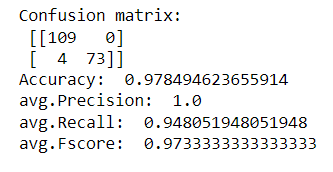

### 4.2)Regressor
- Model: RandomForest Regressor, trees=200

**Scores**
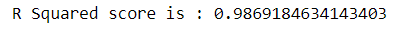

**Visualizing Regression Output**

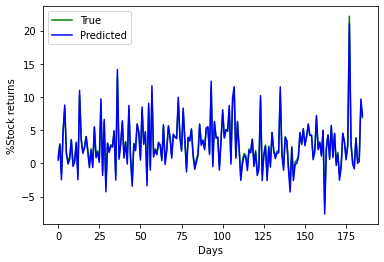

In [33]:
days=[i for i in range(ypred.shape[0])]
plt.plot(days,y2t,color="green",label="True")
plt.plot(days,ypred,color="blue",label="Predicted")
plt.xlabel("Days")
plt.ylabel("%Stock returns")
plt.legend()
plt.show()

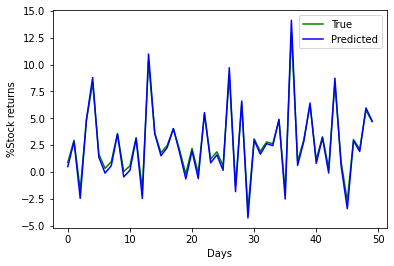

In [34]:
days=[i for i in range(ypred.shape[0])]
plt.plot(days[:50],y2t[:50],color="green",label="True")
plt.plot(days[:50],ypred[:50],color="blue",label="Predicted")
plt.xlabel("Days")
plt.ylabel("%Stock returns")
plt.legend()
plt.show()

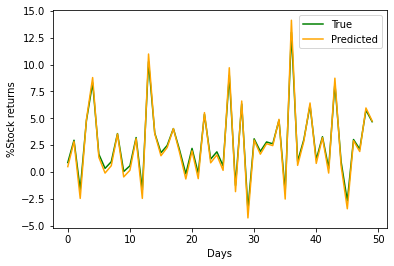

In [35]:
days=[i for i in range(ypred.shape[0])]
plt.plot(days[:50],y2t[:50],color="green",label="True")
plt.plot(days[:50],ypred[:50],color="orange",label="Predicted")
plt.xlabel("Days")
plt.ylabel("%Stock returns")
plt.legend()
plt.show()